In [1]:
import pandas

In [2]:
prediction_deepnet = pandas.read_csv("./deepnet_train_prediction.csv")
prediction_ensemble = pandas.read_csv("./ensemble_train_prediction.csv")

We create the confusion matrix logic and the method to get the result.

In [3]:
def confusion_matrix(row):
    x = "TN"
    if row['SeriousDlqin2yrs'] == 1:
        if row['Prediction'] == 1:
            x = "TP"
        else:
            x = "FN"
    else:
        if row['Prediction'] == 1:
            x = "FP"
    return x

In [4]:
def get_confusion_matrix(dataframe): 
    dataframe['Error'] = dataframe.apply(confusion_matrix, axis=1)
    return dataframe['Error'].value_counts()

In [5]:
print(f"Ensemble : {get_confusion_matrix(prediction_ensemble)}")
print(f"Deepnet : {get_confusion_matrix(prediction_deepnet)}")

Ensemble : TN    27708
FN     1699
TP      358
FP      235
Name: Error, dtype: int64
Deepnet : TN    27255
FN     1423
FP      688
TP      634
Name: Error, dtype: int64


To get the **Accuracy** we add the **True Positives** and **True Negatives** and we divide them by **sample size/100**.

In [6]:
def get_accuracy(dataframe):
    final_confusion_matrix = get_confusion_matrix(dataframe)
    accuracy = (final_confusion_matrix['TP'] + final_confusion_matrix['TN'])/300
    print(accuracy)

print("Ensemble")    
get_accuracy(prediction_ensemble)
print("Deepnet")
get_accuracy(prediction_deepnet)

Ensemble
93.55333333333333
Deepnet
92.96333333333334


We can have a look at the **100 largest errors**, with the **highest probability**.

In [7]:
filtered = prediction_deepnet.loc[prediction_deepnet['Error'].isin(["FN", "FP"])]

filtered = (filtered.nlargest(100, 'probability'))

From the given cost matrix we evaluate the best threshold to maximize our cash gain.

In [8]:
def cost_threshold(dataframe, threshold):
    prediction_threshold = dataframe['1 probability'] > threshold

    P_pred = prediction_threshold
    N_pred = ~prediction_threshold

    P_real = (dataframe['SeriousDlqin2yrs'] == 1)
    N_real = (dataframe['SeriousDlqin2yrs'] == 0)

    TP = len(dataframe.loc[P_pred & P_real])
    TN = len(dataframe.loc[N_pred & N_real])
    FP = len(dataframe.loc[P_pred & N_real])
    FN = len(dataframe.loc[N_pred & P_real])

    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500

    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost

    return cost

With the **matplotlib** library we draw a plot to get the maximum cash gain value with it's matching threshold.

In [9]:
import matplotlib.pyplot as plt
def get_max_threshold(dataframe):
    table = [cost_threshold(dataframe, n/1000) for n in range(0,1000)]
    plt.plot(table)
    max_val = max(table)
    max_threshold = table.index(max_val)/3000
    print(f'Le gain maximum est {max_val} et il est obtenu avec un seuil de {max_threshold}')

Le gain maximum est 9970500 et il est obtenu avec un seuil de 0.09433333333333334
Le gain maximum est 9824000 et il est obtenu avec un seuil de 0.14133333333333334


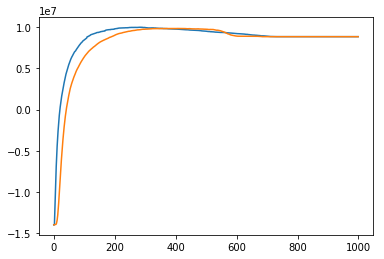

In [10]:
get_max_threshold(prediction_ensemble)
get_max_threshold(prediction_deepnet)

To get the **AUC** we compare the **TP** probability score to the **TN** probability score.

In [11]:
def auc_method(dataframe):
    auc_ratio = 0
    auc_count = 0
    auc_p_filter = dataframe.loc[dataframe['Error'].isin(["TP", "FN"])]
    auc_n_filter = dataframe.loc[dataframe['Error'].isin(["TN", "FP"])]
    
    for p_value in auc_p_filter['1 probability']:
        for n_value in auc_n_filter['1 probability']:
            if p_value > n_value:
                auc_ratio += 1
            auc_count += 1

    print(f"Number of comparisons : {auc_ratio}")
    return auc_ratio/auc_count

In [12]:
print("Ensemble")
print(auc_method(prediction_ensemble))
print("Deepnet")
print(auc_method(prediction_deepnet))

Ensemble
Number of comparisons : 49267257
0.8571386145812389
Deepnet
Number of comparisons : 48522786
0.8441865064186937
